# Proyecto Final

_Jorge III Altamirano Astorga - 175904_

In [671]:
from bs4 import BeautifulSoup
import bs4 as bs4
import requests
import sys
from dateutil import parser #esta lib es más útil que la de Python para interpretar fechas parciales, como las de Twitter
import re
import datetime
import pandas as pd
from string import punctuation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection  import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentAnalyzer
from sklearn.naive_bayes import MultinomialNB

## BMV IPC

In [359]:
ipc = pd.read_csv("bmv_ipc.csv", sep=',')
ipc.Date = pd.to_datetime(ipc.Date)
#quitamos columnas menos relevantes para nuestro análisis
ipc = ipc.drop(["Open", "High", "Low", "Close"], axis=1)
#quito espacios
ipc = ipc.rename({"Adj Close": "close", "Volume": "volume", "Date": "date"}, axis="columns")
#sacamos la diferencia porcentual del cierre del día anterior
ipc["deltaPct"] = 100 * (1 - ipc["close"].shift(1) / ipc["close"])
ipc.dtypes

date        datetime64[ns]
close              float64
volume             float64
deltaPct           float64
dtype: object

In [360]:
ipc.describe()

,close,volume,deltaPct
count,1308.000000,1.308000e+03,1306.000000
mean,45570.715782,1.879798e+08,-0.004675
std,2959.270114,8.189003e+07,0.853486
min,37950.968750,0.000000e+00,-6.171380
25%,43402.067383,1.442206e+08,-0.461086
50%,45300.835938,1.760186e+08,0.021904
75%,48050.900391,2.149562e+08,0.509949
max,51713.378906,6.966092e+08,3.463701


### Comportamiento del IPC

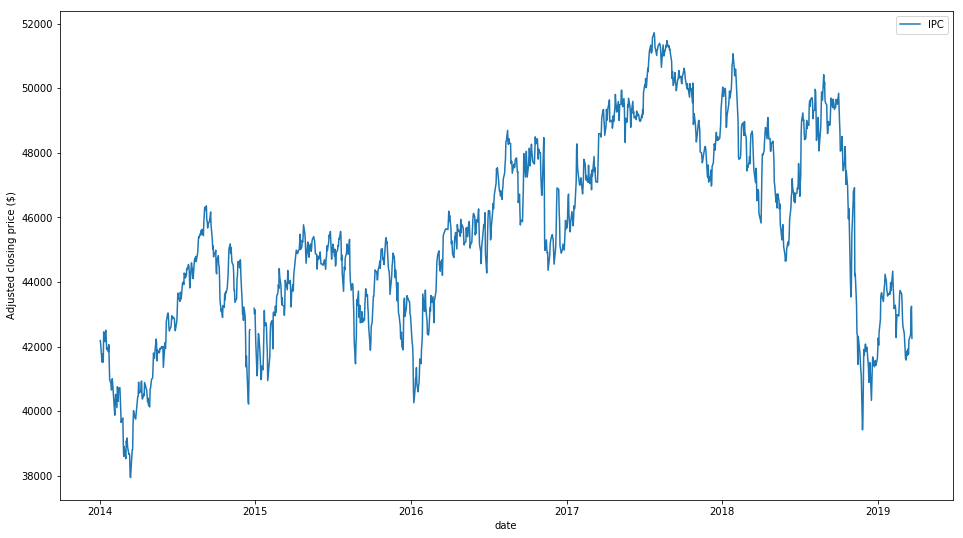

In [361]:
%matplotlib inline

# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(ipc.date, ipc.close, label='IPC')
# ax.plot(short_rolling_msft.index, short_rolling_msft, label='20 days rolling')
# ax.plot(long_rolling_msft.index, long_rolling_msft, label='100 days rolling')

ax.set_xlabel('date')
ax.set_ylabel('Adjusted closing price ($)')
ax.legend()
plt.show()

### Densidad

Hicimos una función _lag_ con el fin de comporar el cierre de una fecha con la del día anterior, esto de manera porcentual tienen una distribución la cual se observa como sigue.

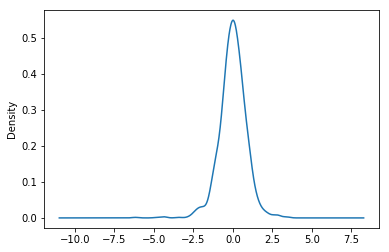

In [362]:
%matplotlib inline
ipc["deltaPct"].plot(kind="density")

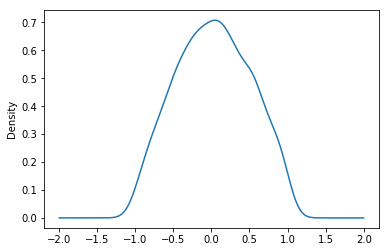

In [363]:
ipc.loc[(ipc.deltaPct >= -1.0) & (ipc.deltaPct <= 1.0), "deltaPct"].plot(kind="density")

Para nuestro análisis de sentimiento y su aprendizaje,
tendremos 3 sentimientos:
    * Negativo (-1): cuando el cambio en el IPC de la BMV sea menor o igual a -0.5% respecto al cierre del día anterior
    * Neutral (0): cuando el cambio en el IPC de la BMV sea mayor a -0.5% y menor a +0.5% respecto al cierre del día anterior
    * Positivo (+1): cuando el cambio en el IPC de la BMV sea mayor o igual a +0.5%
    
Estos números lo tomamos de la distribución de los datos, en los cuales el 25% 

**Nota:** crearemos una columna, la cual tendrá el posible análisis de sentimiento, el cual posteriormente aplicaremos el modelo de Lenguaje Natural, para intentar extraer el sentimiento basado en el comportamiento del día anterior y los tweets que mencionen palabras clave relacionados con la BMV.

In [364]:
ipc.loc[ipc.deltaPct <= -0.5, "sentiment"] = -1
ipc.loc[ipc.deltaPct >= +0.5, "sentiment"] = 1
ipc.loc[ipc.sentiment.isna(), "sentiment"] = 0
ipc.head()

,date,close,volume,deltaPct,sentiment
0,2014-01-02,42188.449219,139707400.0,NaN,0.0
1,2014-01-03,42064.968750,141022700.0,-0.293547,0.0
2,2014-01-06,41525.949219,157899200.0,-1.298031,-1.0
3,2014-01-07,41778.601563,174828600.0,0.604741,1.0
4,2014-01-08,41515.488281,208777500.0,-0.633771,-1.0


## Sentiment Analysis

### Extracción y Obtención de Tweets

In [680]:
def extract_tweets(soup, file, i, year, silent=False):
    tweets = soup.find_all("table", attrs={"class": "tweet"})
    # soup.find_all("div", attrs={"class": "tweet-text"})
    # tweet = tweets[0]
    for tweet in tweets:
        tweet_text = tweet.find_all('div', attrs={'class': 'tweet-text'})
        tweet_date = tweet.find_all("td", attrs={'class': 'timestamp'})
        for text in tweet_text:
            if type(text) == bs4.element.Tag:
                txt = re.sub("(eleconomista\.com\.mx|pic\.twitter\.com|bit\.ly|bitly\.com)/[^ ]*", " ", text.text).strip()
                txt = re.sub("(\||\n)", " ", txt)
                file.write(txt + "|")
        for date in tweet_date:
            if type(date) == bs4.element.Tag:
                date = date.text.strip() 
                if re.match("[0-9]*[smh]$", date, re.IGNORECASE) is not None: #detectar si son horas, poner fecha actual
                    date = str(datetime.datetime.now())[0:10] + ' 00:00:00'
                else:
                    if len(date) > 6: #detectamos si es una fecha corta (Mar 18) y que no corte el día
                        date = re.sub(year[-2:] + "$", "", date)
                    date = str(parser.parse(date + " " + year) ) 
                file.write(date + "|%s"%i + "\n")
                

In [681]:
def get_tweets(query="bolsa OR IPC OR BMV", newspaper="elfinanciero_mx", year="2018", filename="file", silent=False):
    q = 'https://mobile.twitter.com/search?q=' + query + \
          '%20from%3A' + newspaper + \
          '%20since%3A'+year+'-01-01%20until%3A'+year+'-12-31&src=typd&lang=en'

    with open("%s.%s.csv"%(filename,year), "wt") as file:
        i = 0
        q = 'https://mobile.twitter.com/search?q=' + query + \
        '%20from%3A' + newspaper + '%20since%3A' + year + \
        '-01-01%20until%3A' + year +'-12-31&src=typd&lang=en'
        file.write("tweet|time|page\n") #header
        while(True): #loop para extraer todas las páginas 
            if silent == False:
                print("  Downloading page %d..."%(i+1))
            try:
                response = requests.get(q)
            except:
                raise Exception("Error al obtener página de resultados.")
            if response.status_code != 200:
                raise Exception("Error (!= 200) al obtener página de resultados.")
            
#             with open("%s_%d.html"%(query,i), 'w') as html:
#                html.write(response.text)
            
            soup = BeautifulSoup(response.text, 'lxml') #abre la primera página de búsqueda de twitter
            extract_tweets(soup, file, i, year)

            nx = soup.find("a", text=" Load older Tweets ")
            if nx != None and nx.has_attr('href'):
                q = "https://mobile.twitter.com" + nx.get_attribute_list('href')[0]
            else:
                break
            i += 1
    if silent == False:
        print("  Done!")

In [685]:
%%time
for yr in ["2014", "2015", "2016", "2017", "2018", "2019"]:
    for source in ["elfinanciero_mx", "eleconomista"]:
        print("Downloading year %s from @%s"%(yr,source))
        get_tweets(query="bolsa OR IPC OR BMV", newspaper=source, year=yr, filename="tweets.raw/bmv.%s"%source)

  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
CPU times: user 10.4 s, sys: 396 ms, total: 10.8 s
Wall time: 1min 12s


### Limpiar columnas

In [365]:
df = pd.read_csv("tweets.raw/bmv.elfinanciero_mx.2014.csv", sep="|")
df = df.append(pd.read_csv("tweets.raw/bmv.elfinanciero_mx.2015.csv", sep="|"))
df = df.append(pd.read_csv("tweets.raw/bmv.elfinanciero_mx.2016.csv", sep="|"))
df = df.append(pd.read_csv("tweets.raw/bmv.elfinanciero_mx.2017.csv", sep="|"))
df = df.append(pd.read_csv("tweets.raw/bmv.elfinanciero_mx.2018.csv", sep="|"))
df = df.append(pd.read_csv("tweets.raw/bmv.elfinanciero_mx.2019.csv", sep="|"))
df["source"] = "elfinanciero_mx"
df = df.append(pd.read_csv("tweets.raw/bmv.eleconomista.2014.csv", sep="|"))
df = df.append(pd.read_csv("tweets.raw/bmv.eleconomista.2015.csv", sep="|"))
df = df.append(pd.read_csv("tweets.raw/bmv.eleconomista.2016.csv", sep="|"))
df = df.append(pd.read_csv("tweets.raw/bmv.eleconomista.2017.csv", sep="|"))
df = df.append(pd.read_csv("tweets.raw/bmv.eleconomista.2018.csv", sep="|"))
df = df.append(pd.read_csv("tweets.raw/bmv.eleconomista.2019.csv", sep="|"))
df["source"] = np.where(pd.isna(df["source"]), "eleconomista", df.source)
df.time = pd.to_datetime(df.time)
df.tweet = df.tweet.astype("str")
df.source = df.source.astype("str")
df = df.drop(columns=["page"])
df.dtypes

source            object
time      datetime64[ns]
tweet             object
dtype: object

In [366]:
#ordenar columnas 
df = df.sort_values(by=["time"])
#reindizar
df.index = range(0, df.shape[0])
# print(df.head(5))
(df.tail(5))

,source,time,tweet
2398,eleconomista,2019-03-22,"Según la Bolsa Mexicana de Valores, la confian..."
2399,eleconomista,2019-03-22,Pinterest 📷 prepara su entrada al New York Sto...
2400,elfinanciero_mx,2019-03-22,Bolsa mexicana sufre primer revés de la semana...
2401,elfinanciero_mx,2019-03-22,"Pinterest, una de las empresas 'unicornio' que..."
2402,eleconomista,2019-03-22,La Bolsa Mexicana de Valores acumuló una ganan...


In [168]:
df.to_csv("tweets.csv.xz", compression="xz", index=False)
df.shape

(2403, 3)

In [659]:
df = pd.read_csv("tweets.csv.xz", compression="xz")
df["time"] = pd.to_datetime(df.time)
df.head(1)

,source,time,tweet
0,elfinanciero_mx,2014-01-01,#BMV superaría los 46 mil puntos en 2014: Accival


### NLP

De manera experimental realizaremos un entrenamiento con el sentimiento que obtuvimos en el paso anterior (IPC), y lo asignaremos a los valores de la misma fecha del tweet.

In [662]:
df.drop(columns=["sentiment"], inplace=True, errors="ignore")
#sentimiento basado en el porcentaje de cambio del ipc
df["ipc"] = df.join(ipc.set_index("date"), on="time", how="left").deltaPct.round(0)
#sentimiento basado en reglas
df["sentiment"] = df.join(ipc.set_index("date"), on="time", how="left").sentiment
df.head(5)

,source,time,tweet,ipc,sentiment
0,elfinanciero_mx,2014-01-01,#BMV superaría los 46 mil puntos en 2014: Accival,NaN,NaN
1,elfinanciero_mx,2014-01-02,GRÁFICA. ¿Quiénes ganaron y quiénes perdieron ...,NaN,0.0
2,elfinanciero_mx,2014-01-02,#Mercados #BMV cae 1.12% por toma de utilidade...,NaN,0.0
3,elfinanciero_mx,2014-01-02,#Mercados #BMV avanza 0.22% en primer sesión d...,NaN,0.0
4,elfinanciero_mx,2014-01-02,10 ganadoras y 10 perdedoras en la #BMV durant...,NaN,0.0


Existen fechas en las cuales no opera la bolsa, pero sí existen tweets publicados; por lo que es conveniente aplicar dicho tweet al cierre de la jornada del siguiente día hábil para la bolsa. Se puede observar en la salida anterior, el caso de un 1 de Enero, donde la bolsa no laboró. Pero el 2 de enero sí, entonces, dicho tweet aplica para el 2 de Enero. 

Lo mismo aplica para tweets que son publicados en Sábado o Domingo, por lo que aplicamos el sentimiento del siguiente día hábil.

In [831]:
def tweet_adjust_df(df, columns=["sentiment", "ipc"]):
    for col in columns:
        i = -1
        while np.any(df[col].isnull()):
            df["sent_lag"] = df.shift(-1)[col]
            df.loc[df[col].isna(), col] = df.loc[df[col].isna(), "sent_lag"]
            i -= 1
            if i < -15:
                break
        i = -1
        if np.any(df.iloc[-1].isna()):
            j = df.loc[df[col].isna()].index
            df.drop(j, axis=0, inplace=True)
    df.drop(columns="sent_lag", inplace=True, errors="ignore")
    return df
df = tweet_adjust_df(df, ["ipc", "sentiment"]).copy()
df.head(3)

,source,time,tweet,ipc,sentiment
0,elfinanciero_mx,2014-01-01,#BMV superaría los 46 mil puntos en 2014: Accival,-0.0,0.0
1,elfinanciero_mx,2014-01-02,GRÁFICA. ¿Quiénes ganaron y quiénes perdieron ...,-0.0,0.0
2,elfinanciero_mx,2014-01-02,#Mercados #BMV cae 1.12% por toma de utilidade...,-0.0,0.0


Dado que El Financiero y El Economista publican en español utilizaremos las reglas y raíces de este nuestro idioma.

In [673]:
stop_words = stopwords.words('spanish')
stemmer = nltk.stem.SnowballStemmer('spanish')
non_words = list(punctuation)
non_words.extend(['¿', '¡'])

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed
def tokenize(text):
    text = ''.join([c for c in text if c not in non_words])
    tokens = word_tokenize(text)
    # stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems

### Separación en conjunto de entrenamiento y pruebas

Separamos nuestro data set, con semilla estática, para separa nuestro set en datos de entrenamiento y prueba de manera reproducible.

In [674]:
train, test = train_test_split(df, test_size=0.4, random_state=175904)
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)
train = train.copy()
test = test.copy()
print("Tamaño de conjuntos de datos:\nEntrenamiento: %d (%f%%)\nPrueba: %d (%f%%)"%(
    train.shape[0], 100*train.shape[0]/df.shape[0], 
    test.shape[0], 100*test.shape[0]/df.shape[0]))

Tamaño de conjuntos de datos:
Entrenamiento: 1441 (59.966708%)
Prueba: 962 (40.033292%)


In [675]:
pipe0 = Pipeline([
    ("token", CountVectorizer(tokenizer=tokenize, stop_words=stop_words)),
    ("tfid", TfidfTransformer()),
    ("clf", MultinomialNB(alpha=1.0))
])
pipe0m0 = pipe0.fit(train.tweet, train.sentiment)
pipe0m1 = pipe0.fit(train.tweet, train.ipc)
train["sentiment_hat"] = pipe0m0.predict(train.tweet)
train["ipc_hat"] = pipe0m1.predict(train.tweet)
train.head()

,source,time,tweet,ipc,sentiment,sentiment_hat,ipc_hat
0,elfinanciero_mx,2016-03-04,Bolsa brasileña sube con fuerza tras interroga...,0.0,0.0,-0.0,-0.0
1,eleconomista,2016-07-20,"¿Piensas invertir en la bolsa?, aquí te damos ...",1.0,1.0,1.0,1.0
2,eleconomista,2015-09-14,Las principales acciones mexicanas que cotizan...,0.0,0.0,-0.0,-0.0
3,elfinanciero_mx,2014-02-24,#EFMercados: La BMV registró un pequeño avance...,0.0,0.0,-0.0,-0.0
4,elfinanciero_mx,2016-12-07,#LOÚLTIMO ICA se dispara en Bolsa tras alianza...,1.0,1.0,-0.0,-0.0


### Métricas para Modelo basado en Sentimiento

Basamos nuestro modelo en 2 sentimientos: que sube (+1), neutro (0) y que baja (-1)

In [676]:
test["sentiment_hat"] = pipe0m0.predict(test.tweet)
print(classification_report(test.sentiment, test.sentiment_hat))

             precision    recall  f1-score   support

       -1.0       0.50      0.01      0.02       252
        0.0       0.50      0.96      0.66       478
        1.0       0.36      0.06      0.11       232

avg / total       0.47      0.49      0.36       962



### Métricas para Modelo Basado en el IPC

Basamos nuestro modelo en el porcentaje de cambio, sin decimales. En más de 4 años ha habido movimiento entre el -6% y el 3%.

In [677]:
ipc.deltaPct.describe()

count    1306.000000
mean       -0.004675
std         0.853486
min        -6.171380
25%        -0.461086
50%         0.021904
75%         0.509949
max         3.463701
Name: deltaPct, dtype: float64

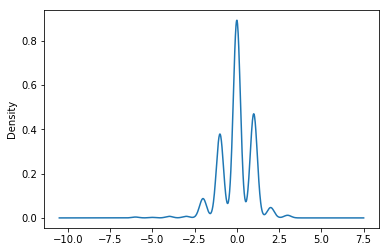

In [678]:
df.ipc.plot(kind="density")

In [679]:
test["ipc_hat"] = pipe0m1.predict(test.tweet)
print(classification_report(test.ipc, test.ipc_hat))

             precision    recall  f1-score   support

       -6.0       0.00      0.00      0.00         3
       -5.0       0.00      0.00      0.00         3
       -4.0       0.00      0.00      0.00         6
       -3.0       0.00      0.00      0.00         2
       -2.0       0.00      0.00      0.00        44
       -1.0       0.50      0.01      0.02       194
        0.0       0.50      0.96      0.66       478
        1.0       0.33      0.07      0.11       209
        2.0       0.00      0.00      0.00        15
        3.0       0.00      0.00      0.00         8

avg / total       0.42      0.49      0.35       962



/opt/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Tweets de Tasas de Interés

Dado que aún nuestro mejor resultado en nuestro modelo pasado, vamos a intentar utilizar otros términos de búsqueda: Tasas de Interés, Bonos y Cetes

In [686]:
%%time
for yr in ["2014", "2015", "2016", "2017", "2018", "2019"]:
    for source in ["elfinanciero_mx", "eleconomista"]:
        print("Downloading year %s from @%s"%(yr,source))
        get_tweets(query='"tasas de interés" OR cetes OR bonos', newspaper=source, year=yr, filename="tweets.raw/cetes.%s"%source, silent=False)

  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
CPU times: user 3.63 s, sys: 73.2 ms, total: 3.7 s
Wall time: 27.5 s


In [698]:
cetes = pd.read_csv("tweets.raw/cetes.elfinanciero_mx.2014.csv", sep="|")
cetes = cetes.append(pd.read_csv("tweets.raw/cetes.elfinanciero_mx.2015.csv", sep="|"))
cetes = cetes.append(pd.read_csv("tweets.raw/cetes.elfinanciero_mx.2016.csv", sep="|"))
cetes = cetes.append(pd.read_csv("tweets.raw/cetes.elfinanciero_mx.2017.csv", sep="|"))
cetes = cetes.append(pd.read_csv("tweets.raw/cetes.elfinanciero_mx.2018.csv", sep="|"))
cetes = cetes.append(pd.read_csv("tweets.raw/cetes.elfinanciero_mx.2019.csv", sep="|"))
cetes["source"] = "elfinanciero_mx"
cetes = cetes.append(pd.read_csv("tweets.raw/cetes.eleconomista.2014.csv", sep="|"))
cetes = cetes.append(pd.read_csv("tweets.raw/cetes.eleconomista.2015.csv", sep="|"))
cetes = cetes.append(pd.read_csv("tweets.raw/cetes.eleconomista.2016.csv", sep="|"))
cetes = cetes.append(pd.read_csv("tweets.raw/cetes.eleconomista.2017.csv", sep="|"))
cetes = cetes.append(pd.read_csv("tweets.raw/cetes.eleconomista.2018.csv", sep="|"))
cetes = cetes.append(pd.read_csv("tweets.raw/cetes.eleconomista.2019.csv", sep="|"))
cetes["source"] = np.where(pd.isna(cetes["source"]), "eleconomista", cetes.source)
cetes.time = pd.to_datetime(cetes.time)
cetes.tweet = cetes.tweet.astype("str")
cetes.source = cetes.source.astype("str")
cetes = cetes.drop(columns=["page"])
cetes.dtypes

source            object
time      datetime64[ns]
tweet             object
dtype: object

In [699]:
#ordenar columnas 
cetes = cetes.sort_values(by=["time"])
#reindizar
cetes.index = range(0, cetes.shape[0])

cetes.tail(5)

,source,time,tweet
794,eleconomista,2019-03-14,Las solicitudes de corporativos mexicanos para...
795,eleconomista,2019-03-15,#Volkswagen recaudó miles de millones en bonos...
796,eleconomista,2019-03-20,La #Fed ya no prevé subir sus tasas de interés...
797,eleconomista,2019-03-22,"Jorge Alegría, asesor senior presidente CME Cl..."
798,eleconomista,2019-03-24,"Uber pagaría 1,400 millones de dólares en efec..."


In [708]:
cetes.to_csv("cetes.csv.xz", compression="xz", index=False)
cetes.shape

(799, 3)

In [798]:
cetes = pd.read_csv("cetes.csv.xz", compression="xz")
cetes["time"] = pd.to_datetime(cetes.time)
cetes.head(1)

,source,time,tweet
0,eleconomista,2014-01-01,#Podcast Qué es y cómo funciona el programa ...


In [799]:
cetes.drop(columns=["sentiment"], inplace=True, errors="ignore")
#sentimiento basado en el porcentaje de cambio del ipc
cetes["ipc"] = cetes.join(ipc.set_index("date"), on="time", how="left").deltaPct.round(0)
#sentimiento basado en reglas
cetes["sentiment"] = cetes.join(ipc.set_index("date"), on="time", how="left").sentiment
cetes.head(5)

,source,time,tweet,ipc,sentiment
0,eleconomista,2014-01-01,#Podcast Qué es y cómo funciona el programa ...,NaN,NaN
1,eleconomista,2014-01-07,Tasa líder de #Cetes sube a 3.17% ow.ly/smiWM,1.0,1.0
2,elfinanciero_mx,2014-01-07,Tasas de interés mixtas en subasta primaria de...,1.0,1.0
3,eleconomista,2014-01-09,#Bonos M con presiones al alza en corto plazo:...,0.0,0.0
4,elfinanciero_mx,2014-01-13,@FEMSA colocó una reapertura de sus bonos a 10...,-1.0,-1.0


Como en el caso anterior, existen fechas en las cuales no opera la bolsa, pero sí existen tweets publicados; por lo que es conveniente aplicar dicho tweet al cierre de la jornada del siguiente día hábil para la bolsa. Se puede observar en la salida anterior, el caso de un 1 de Enero, donde la bolsa no laboró. Pero el 2 de enero sí, entonces, dicho tweet aplica para el 2 de Enero. 

Lo mismo aplica para tweets que son publicados en Sábado o Domingo, por lo que aplicamos el sentimiento del siguiente día hábil.

# _Revisar_

In [828]:
cetes = tweet_adjust_df(cetes, ["ipc", "sentiment"]).copy()
cetes.head()

,source,time,tweet,ipc,sentiment
0,eleconomista,2014-01-01,#Podcast Qué es y cómo funciona el programa ...,1.0,1.0
1,eleconomista,2014-01-07,Tasa líder de #Cetes sube a 3.17% ow.ly/smiWM,1.0,1.0
2,elfinanciero_mx,2014-01-07,Tasas de interés mixtas en subasta primaria de...,1.0,1.0
3,eleconomista,2014-01-09,#Bonos M con presiones al alza en corto plazo:...,0.0,0.0
4,elfinanciero_mx,2014-01-13,@FEMSA colocó una reapertura de sus bonos a 10...,-1.0,-1.0


### Separación en conjunto de entrenamiento y pruebas

Separamos nuestro data set, con semilla estática, para separa nuestro set en datos de entrenamiento y prueba de manera reproducible.

In [803]:
train2, test2 = train_test_split(cetes, test_size=0.4, random_state=175904)
train2.reset_index(drop=True,inplace=True)
test2.reset_index(drop=True,inplace=True)
train2 = train2.copy()
test2 = test2.copy()
print("Tamaño de conjuntos de datos:\nEntrenamiento: %d (%f%%)\nPrueba: %d (%f%%)"%(
    train2.shape[0], 100*train2.shape[0]/cetes.shape[0], 
    test2.shape[0], 100*test2.shape[0]/cetes.shape[0]))

Tamaño de conjuntos de datos:
Entrenamiento: 478 (59.899749%)
Prueba: 320 (40.100251%)


In [804]:
pipe1 = Pipeline([
    ("token", CountVectorizer(tokenizer=tokenize, stop_words=stop_words)),
    ("tfid", TfidfTransformer()),
    ("clf", MultinomialNB(alpha=1.0))
])
pipe1m0 = pipe1.fit(train2.tweet, train2.sentiment)
pipe1m1 = pipe1.fit(train2.tweet, train2.ipc)
train2["sentiment_hat"] = pipe1m0.predict(train2.tweet)
train2["ipc_hat"] = pipe1m1.predict(train2.tweet)
train2.head()

,source,time,tweet,ipc,sentiment,sentiment_hat,ipc_hat
0,elfinanciero_mx,2016-06-10,"#Análisis Tasa real de Cetes, en máximos de 5 ...",-1.0,-1.0,0.0,0.0
1,elfinanciero_mx,2016-10-18,#Opinión Benito Solís te explica los costos ec...,1.0,1.0,0.0,0.0
2,eleconomista,2017-03-16,Aeropuerto y CDMX van por bonos verdes ow.ly/W...,1.0,1.0,1.0,1.0
3,elfinanciero_mx,2016-01-13,#Análisis ¿Bonos Bowie? Él también será record...,-0.0,0.0,0.0,0.0
4,eleconomista,2017-02-12,HR Ratings podría calificar 3 bonos verdes en ...,-0.0,0.0,0.0,0.0


### Métricas para Modelo basado en Sentimiento

Basamos nuestro modelo en 2 sentimientos: que sube (+1), neutro (0) y que baja (-1)

In [805]:
test2["sentiment_hat"] = pipe1m0.predict(test2.tweet)
print(classification_report(test2.sentiment, test2.sentiment_hat))

             precision    recall  f1-score   support

       -1.0       1.00      0.01      0.02        84
        0.0       0.47      0.96      0.63       139
        1.0       0.48      0.15      0.23        97

avg / total       0.61      0.47      0.35       320



### Métricas para Modelo Basado en el IPC

In [806]:
test2["ipc_hat"] = pipe1m1.predict(test2.tweet)
print(classification_report(test2.ipc, test2.ipc_hat))

             precision    recall  f1-score   support

       -4.0       0.00      0.00      0.00         1
       -3.0       0.00      0.00      0.00         1
       -2.0       0.00      0.00      0.00        14
       -1.0       1.00      0.01      0.03        68
        0.0       0.47      0.96      0.63       139
        1.0       0.48      0.16      0.25        91
        2.0       0.00      0.00      0.00         6

avg / total       0.55      0.47      0.35       320



/opt/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Tweets de Divisas

Dado que aún nuestro mejor resultado en nuestro modelo pasado, vamos a intentar utilizar otros términos de búsqueda: peso, divisa, Dólar, Euro, Libra.

In [807]:
%%time
for yr in ["2014", "2015", "2016", "2017", "2018", "2019"]:
    for source in ["elfinanciero_mx", "eleconomista"]:
        print("Downloading year %s from @%s"%(yr,source))
        get_tweets(query='peso OR divisa OR dollar OR dolar OR usd OR euro OR libra',
                   newspaper=source, year=yr, filename="tweets.raw/forex.%s"%source, silent=False)

  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
CPU times: user 15.3 s, sys: 416 ms, total: 15.7 s
Wall time: 1min 42s


In [808]:
forex = pd.read_csv("tweets.raw/forex.elfinanciero_mx.2014.csv", sep="|")
forex = forex.append(pd.read_csv("tweets.raw/forex.elfinanciero_mx.2015.csv", sep="|"))
forex = forex.append(pd.read_csv("tweets.raw/forex.elfinanciero_mx.2016.csv", sep="|"))
forex = forex.append(pd.read_csv("tweets.raw/forex.elfinanciero_mx.2017.csv", sep="|"))
forex = forex.append(pd.read_csv("tweets.raw/forex.elfinanciero_mx.2018.csv", sep="|"))
forex = forex.append(pd.read_csv("tweets.raw/forex.elfinanciero_mx.2019.csv", sep="|"))
forex["source"] = "elfinanciero_mx"
forex = forex.append(pd.read_csv("tweets.raw/forex.eleconomista.2014.csv", sep="|"))
forex = forex.append(pd.read_csv("tweets.raw/forex.eleconomista.2015.csv", sep="|"))
forex = forex.append(pd.read_csv("tweets.raw/forex.eleconomista.2016.csv", sep="|"))
forex = forex.append(pd.read_csv("tweets.raw/forex.eleconomista.2017.csv", sep="|"))
forex = forex.append(pd.read_csv("tweets.raw/forex.eleconomista.2018.csv", sep="|"))
forex = forex.append(pd.read_csv("tweets.raw/forex.eleconomista.2019.csv", sep="|"))
forex["source"] = np.where(pd.isna(forex["source"]), "eleconomista", forex.source)
forex.time = pd.to_datetime(forex.time)
forex.tweet = forex.tweet.astype("str")
forex.source = forex.source.astype("str")
forex = forex.drop(columns=["page"])
forex.dtypes

source            object
time      datetime64[ns]
tweet             object
dtype: object

In [809]:
#ordenar columnas 
forex = forex.sort_values(by=["time"])
#reindizar
forex.index = range(0, forex.shape[0])

forex.tail(5)

,source,time,tweet
3449,elfinanciero_mx,2019-03-22,El dólar se dispara a 19.40 pesos en bancos.
3450,elfinanciero_mx,2019-03-22,Plazas europeas registran peor jornada desde f...
3451,elfinanciero_mx,2019-03-22,'Viernes negro' para el peso por temor a un me...
3452,eleconomista,2019-03-22,¿Qué le ha favorecido al peso este año? #ElEco...
3453,eleconomista,2019-03-24,La moneda mexicana se mantiene como un activo ...


In [810]:
forex.to_csv("forex.csv.xz", compression="xz", index=False)
forex.shape

(3454, 3)

In [811]:
forex = pd.read_csv("forex.csv.xz", compression="xz")
forex["time"] = pd.to_datetime(forex.time)
forex.head(1)

,source,time,tweet
0,elfinanciero_mx,2014-01-01,"#Letonia adopta el euro, se convierte en el pa..."


In [812]:
forex.drop(columns=["sentiment"], inplace=True, errors="ignore")
#sentimiento basado en el porcentaje de cambio del ipc
forex["ipc"] = forex.join(ipc.set_index("date"), on="time", how="left").deltaPct.round(0)
#sentimiento basado en reglas
forex["sentiment"] = forex.join(ipc.set_index("date"), on="time", how="left").sentiment
forex.head(5)

,source,time,tweet,ipc,sentiment
0,elfinanciero_mx,2014-01-01,"#Letonia adopta el euro, se convierte en el pa...",NaN,NaN
1,elfinanciero_mx,2014-01-01,#Sitelopediste Peso con mejor desempeño en Lat...,NaN,NaN
2,elfinanciero_mx,2014-01-01,#Dólar se vende dólar a 13.25 pesos en promedi...,NaN,NaN
3,elfinanciero_mx,2014-01-02,#Opinión: @adriantrejo platica cómo el goberna...,NaN,0.0
4,elfinanciero_mx,2014-01-03,"#Opinión En LA DIVISA DEL PODER, @adriantrejo ...",-0.0,0.0


Como en el caso anterior, existen fechas en las cuales no opera la bolsa, pero sí existen tweets publicados; por lo que es conveniente aplicar dicho tweet al cierre de la jornada del siguiente día hábil para la bolsa. Se puede observar en la salida anterior, el caso de un 1 de Enero, donde la bolsa no laboró. Pero el 2 de enero sí, entonces, dicho tweet aplica para el 2 de Enero. 

Lo mismo aplica para tweets que son publicados en Sábado o Domingo, por lo que aplicamos el sentimiento del siguiente día hábil.

# _Revisar_

In [835]:
# def tweet_adjust_df(df, columns=["sentiment", "ipc"]):
#     for col in columns:
#         i = -1
#         while np.any(df[col].isnull()):
#             df["sent_lag"] = df.shift(-1)[col]
#             df.loc[df[col].isna(), col] = df.loc[df[col].isna(), "sent_lag"]
#             i -= 1
#             if i < -15:
#                 break
#         i = -1
#         if np.any(df.iloc[-1].isna()):
#             j = df.loc[df[col].isna()].index
#             df.drop(j, axis=0, inplace=True)
#     df.drop(columns="sent_lag", inplace=True, errors="ignore")
#     return df
forex = tweet_adjust_df(forex, ["ipc", "sentiment"]).copy()
forex.tail(3)

,source,time,tweet,ipc,sentiment
3450,elfinanciero_mx,2019-03-22,Plazas europeas registran peor jornada desde f...,-2.0,-1.0
3451,elfinanciero_mx,2019-03-22,'Viernes negro' para el peso por temor a un me...,-2.0,-1.0
3452,eleconomista,2019-03-22,¿Qué le ha favorecido al peso este año? #ElEco...,-2.0,-1.0


### Separación en conjunto de entrenamiento y pruebas

Separamos nuestro data set, con semilla estática, para separa nuestro set en datos de entrenamiento y prueba de manera reproducible.

In [836]:
train3, test3 = train_test_split(forex, test_size=0.4, random_state=175904)
train3.reset_index(drop=True,inplace=True)
test3.reset_index(drop=True,inplace=True)
train3 = train3.copy()
test3 = test3.copy()
print("Tamaño de conjuntos de datos:\nEntrenamiento: %d (%f%%)\nPrueba: %d (%f%%)"%(
    train3.shape[0], 100*train3.shape[0]/forex.shape[0], 
    test3.shape[0], 100*test3.shape[0]/forex.shape[0]))

Tamaño de conjuntos de datos:
Entrenamiento: 2071 (59.976832%)
Prueba: 1382 (40.023168%)


In [837]:
pipe2 = Pipeline([
    ("token", CountVectorizer(tokenizer=tokenize, stop_words=stop_words)),
    ("tfid", TfidfTransformer()),
    ("clf", MultinomialNB(alpha=1.0))
])
pipe2m0 = pipe2.fit(train3.tweet, train3.sentiment)
pipe2m1 = pipe2.fit(train3.tweet, train3.ipc)
train3["sentiment_hat"] = pipe2m0.predict(train3.tweet)
train3["ipc_hat"] = pipe2m1.predict(train3.tweet)
train3.head()

,source,time,tweet,ipc,sentiment,sentiment_hat,ipc_hat
0,elfinanciero_mx,2016-06-23,"#Brexit Depreciación del peso de 6.68 %, la má...",1.0,1.0,1.0,1.0
1,elfinanciero_mx,2015-07-14,#EFMercados: Dólar rompe a la baja barrera psi...,0.0,0.0,0.0,0.0
2,elfinanciero_mx,2014-05-30,"#Peso sube 1.75% ante el dólar en mayo, su mej...",-2.0,-1.0,0.0,0.0
3,elfinanciero_mx,2017-08-22,"El petróleo, las materias primas agrícolas y e...",0.0,0.0,0.0,0.0
4,elfinanciero_mx,2014-05-19,#Peso regresa a su mejor momento en 5 meses fr...,-0.0,0.0,0.0,0.0


### Métricas para Modelo basado en Sentimiento

Basamos nuestro modelo en 2 sentimientos: que sube (+1), neutro (0) y que baja (-1)

In [839]:
test3["sentiment_hat"] = pipe1m0.predict(test3.tweet)
print(classification_report(test3.sentiment, test3.sentiment_hat))

             precision    recall  f1-score   support

       -1.0       0.33      0.01      0.01       373
        0.0       0.46      0.98      0.63       634
        1.0       0.39      0.03      0.05       375

avg / total       0.41      0.46      0.31      1382



### Métricas para Modelo Basado en el IPC

In [842]:
test3["ipc_hat"] = pipe1m1.predict(test3.tweet)
print(classification_report(test3.ipc, test3.ipc_hat))

             precision    recall  f1-score   support

       -6.0       0.00      0.00      0.00         1
       -5.0       0.00      0.00      0.00         3
       -4.0       0.00      0.00      0.00         2
       -3.0       0.00      0.00      0.00        17
       -2.0       0.00      0.00      0.00        65
       -1.0       0.33      0.01      0.01       285
        0.0       0.46      0.98      0.63       634
        1.0       0.36      0.03      0.06       326
        2.0       0.00      0.00      0.00        38
        3.0       0.00      0.00      0.00        11

avg / total       0.36      0.46      0.30      1382



/opt/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
